<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/C%C3%A9sar/knn_svm_kmeans_16qam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.io import loadmat

## Globales

In [2]:
PARAM_GRID_KNN = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
PARAM_GRID_SVM = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    

def download_file(link):
    # Nombre del archivo
    file = link.split('/')[-1]
    
    # Descarga el archivo si no se ha hecho aún
    !if ! [[ -f "$file" ]]; then wget $link; fi;

    return file


# Función especial para leer todos los datos con la estructura estudiada
def read_data(folder_rx):
    data = {}

    # Leer la carpeta principal
    for folder in os.listdir(folder_rx):
        # Leer las subcarpetas
        if folder.endswith("spacing"):
            data[folder] = {}
            for file in os.listdir(f"{folder_rx}/{folder}"):
                if file.find("consY") != -1:
                    data_name = file.split("_")[2]
                    if data[folder].get(data_name) == None:
                        data[folder][data_name] = {}
                    mat_file_data = loadmat(f"{folder_rx}/{folder}/{file}")
                    data[folder][data_name] = mat_file_data
    return data

# Función para demodular de manera tradicional, usando KNN y SVM
def supervised_demod(X_rx, X_tx, train_size):
    ber = {}
    
    for i, snr in enumerate(X_rx):
        # Extraer información
        X_ch_norm = X_rx[snr].get("const_Y").flatten()
        X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm

        # Arreglos para el BER de cada algoritmo
        trad_ber = np.empty(4)
        knn_ber = np.empty(4)
        svm_ber = np.empty(4)

        for ph in range(4):
            # Rotar constelación
            rotated_X = X_ch*np.exp(ph*1j*np.pi/2)
            
            # Sincronizar de las señales
            synced_X_tx = sofa.sync_signals(X_tx, rotated_X)
            
            # Demodular señal transmitida
            y = sofa.demodulate(synced_X_tx, sofa.MOD_DICT)

            # Mejores parámetros para los algoritmos
            # best_params_knn = sofa.find_best_params(KNeighborsClassifier, PARAM_GRID_KNN, rotated_X, y)
            # best_params_svm = sofa.find_best_params(SVC, PARAM_GRID_SVM, rotated_X, y)
            
            # k = best_params_knn["n_neighbors"] 
            # C = best_params_svm["C"]
            # gamma = best_params_svm["gamma"]
            
            k = 5
            C = 10
            gamma = 0.01
            
            # Demodulación
            trad = sofa.demodulate(rotated_X, sofa.MOD_DICT)
            knn = sofa.demodulate_knn(rotated_X, y, k = k,
                                      train_size = train_size)
            svm = sofa.demodulate_svm(rotated_X, y, C = C, gamma = gamma,
                                      train_size = train_size)
            
            # BER de la demodulación con respecto a la transmitida desplazada
            trad_ber[ph] = sofa.bit_error_rate(trad, y)[0]
            knn_ber[ph] = sofa.bit_error_rate(knn, y)[0]
            svm_ber[ph] = sofa.bit_error_rate(svm, y)[0]

        ber[snr] = {"trad": np.amin(trad_ber),
                    "knn": np.amin(knn_ber),
                    "svm": np.amin(svm_ber)}
        
        # Mensaje para saber que se progresa
        print(f"SNR {snr[5:]} terminado.")
    return ber

def spacing_ber_eval(spacing):
    print(f"Evaluación de algoritmos supervisados para espaciamiento de {spacing} GHz")
    
    ber = supervised_demod(data[f"{spacing}GHz_spacing"], X_tx,
                           train_size = 0.4)
    
    SNR = [snr[5:-2] for snr in list(data[f"{spacing}GHz_spacing"].keys())]
    SNR.sort()
    
    get_ber = lambda algorithm: [ber.get(f"consY{snr_i}dB").get(algorithm) for snr_i in SNR]
    tBER = get_ber("trad")
    kBER = get_ber("knn")
    sBER = get_ber("svm")

    plt.figure(figsize = (10, 6))
    plt.semilogy(SNR, tBER, marker = "^", label = "Tradicional")
    plt.semilogy(SNR, kBER, marker = "x", label = "KNN")
    plt.semilogy(SNR, sBER, marker = "o", label = "SVM")
    plt.title(f"{spacing} GHz spacing")
    plt.xlabel("OSNR (dB)")
    plt.ylabel("BER")
    plt.legend(loc = "upper right")
    plt.grid()
    plt.show()

## Librería de funciones

In [3]:
import sofa

## Datos experimentales

In [4]:
file_tx = "Datos/2x16QAM_16GBd.mat"
folder_rx = "Datos/"

# Datos transmitidos
X_tx_norm = loadmat(file_tx)
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][0].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm

# Leer los datos recibidos
data = read_data(folder_rx)

In [5]:
import datetime
print(f"Inicio: {datetime.datetime.now()}")

Inicio: 2023-02-21 23:13:05.912107


## Espaciamiento de 18 GHz

Evaluación de algoritmos supervisados para espaciamiento de 18 GHz
SNR 40dB terminado.
SNR 35dB terminado.
SNR 32dB terminado.
SNR 30dB terminado.
SNR 27dB terminado.
SNR 19dB terminado.
SNR 23dB terminado.
SNR 25dB terminado.
SNR 20dB terminado.
SNR 18dB terminado.


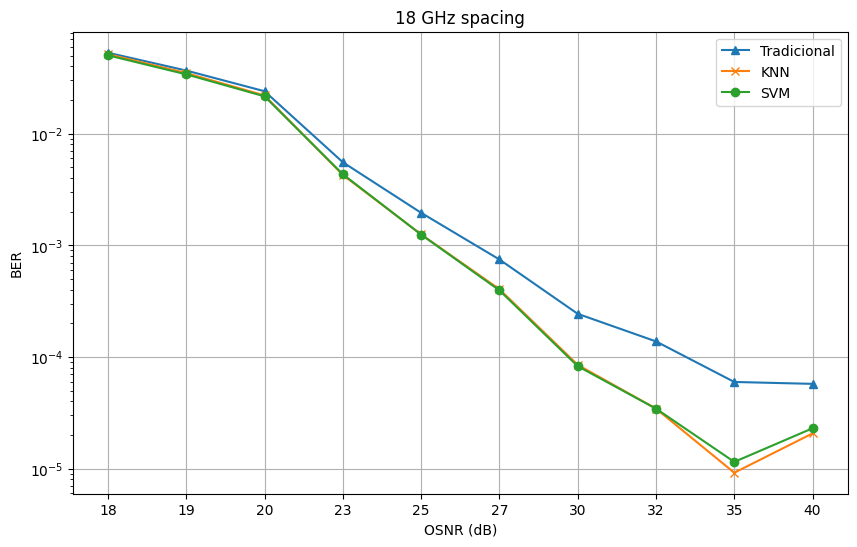

In [6]:
spacing = "18"
spacing_ber_eval(spacing)

## Espaciamiento de 17.6 GHz

Evaluación de algoritmos supervisados para espaciamiento de 17.6 GHz
SNR 40dB terminado.
SNR 35dB terminado.
SNR 32dB terminado.
SNR 30dB terminado.
SNR 27dB terminado.
SNR 25dB terminado.
SNR 23dB terminado.
SNR 20dB terminado.
SNR 19dB terminado.
SNR 18dB terminado.
SNR 21.5dB terminado.


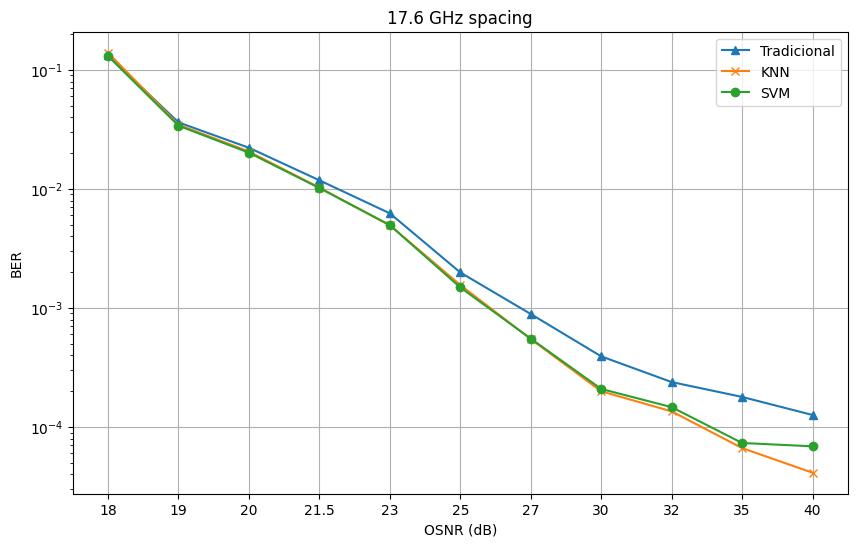

In [7]:
spacing = "17.6"
spacing_ber_eval(spacing)

## Espaciamiento de 17 GHz

Evaluación de algoritmos supervisados para espaciamiento de 17 GHz
SNR 35dB terminado.
SNR 40dB terminado.
SNR 32dB terminado.
SNR 30dB terminado.
SNR 27dB terminado.
SNR 23dB terminado.
SNR 25dB terminado.
SNR 21.5dB terminado.
SNR 20dB terminado.
SNR 19dB terminado.
SNR 18dB terminado.


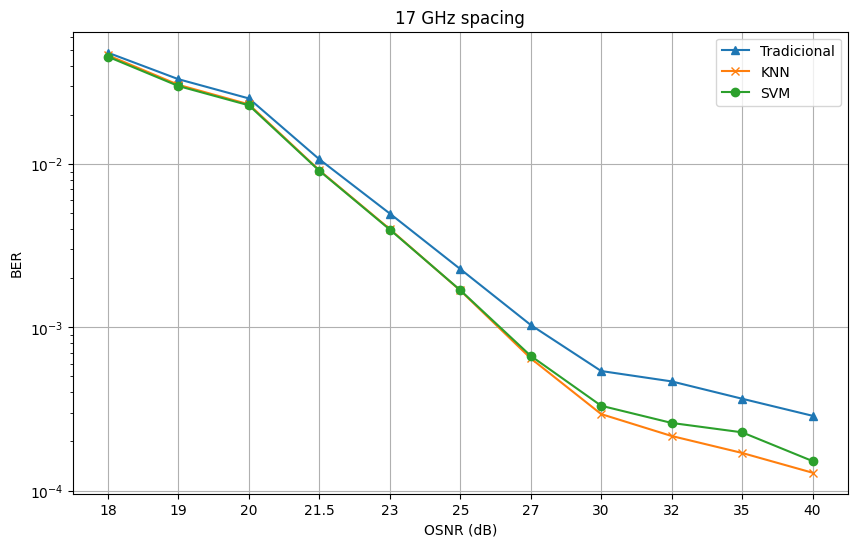

In [8]:
spacing = "17"
spacing_ber_eval(spacing)

## Espaciamiento de 16.5 GHz

Evaluación de algoritmos supervisados para espaciamiento de 16.5 GHz
SNR 30dB terminado.
SNR 35dB terminado.
SNR 32dB terminado.
SNR 40dB terminado.
SNR 27dB terminado.
SNR 23dB terminado.
SNR 21.5dB terminado.
SNR 25dB terminado.
SNR 20dB terminado.
SNR 19dB terminado.
SNR 18dB terminado.


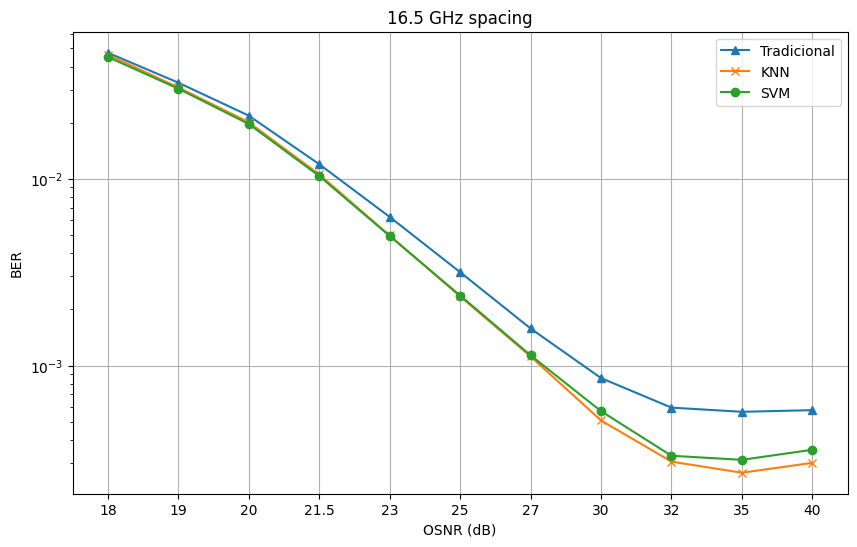

In [9]:
spacing = "16.5"
spacing_ber_eval(spacing)

## Espaciamiento de 16 GHz

Evaluación de algoritmos supervisados para espaciamiento de 16 GHz
SNR 40dB terminado.
SNR 35dB terminado.
SNR 32dB terminado.
SNR 30dB terminado.
SNR 25dB terminado.
SNR 27dB terminado.
SNR 23dB terminado.
SNR 21.5dB terminado.
SNR 20dB terminado.
SNR 19dB terminado.
SNR 18dB terminado.


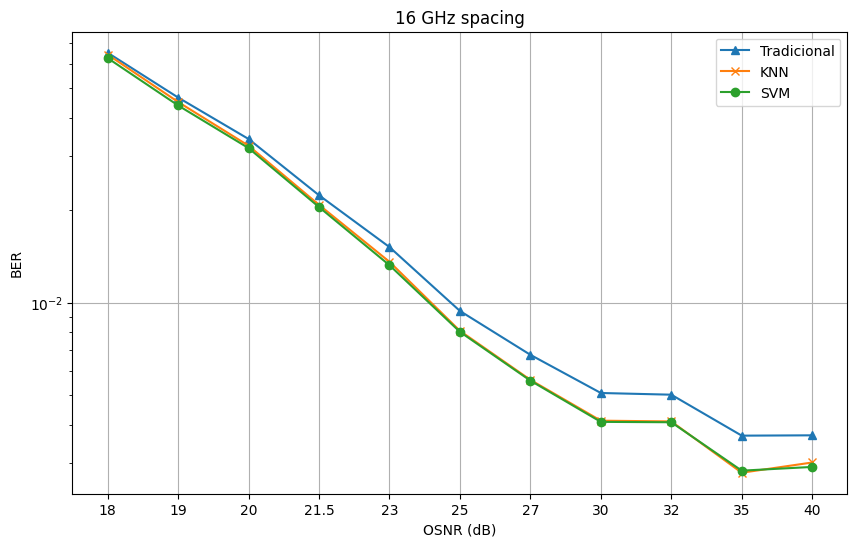

In [10]:
spacing = "16"
spacing_ber_eval(spacing)

## Espaciamiento de 15.5 GHz

Evaluación de algoritmos supervisados para espaciamiento de 15.5 GHz
SNR 25dB terminado.
SNR 30dB terminado.
SNR 32dB terminado.
SNR 40dB terminado.
SNR 27dB terminado.
SNR 35dB terminado.
SNR 23dB terminado.
SNR 21.5dB terminado.
SNR 20dB terminado.


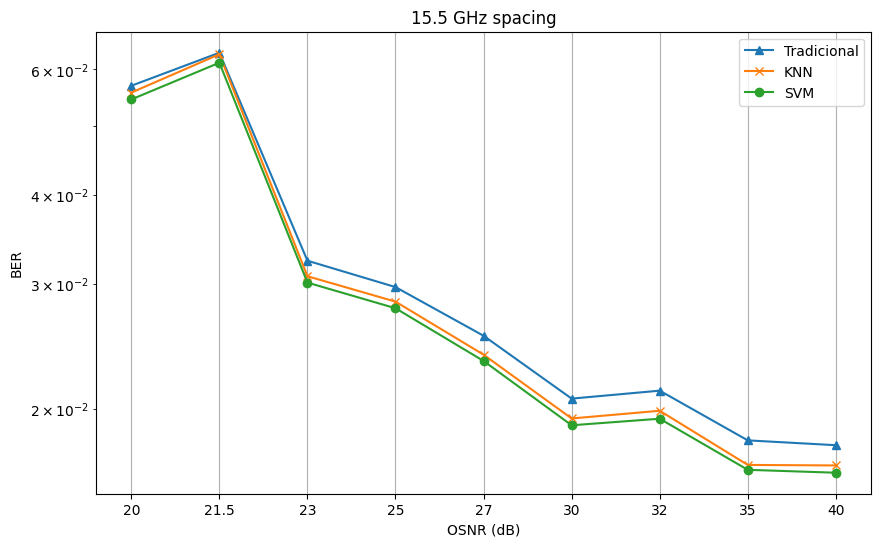

In [11]:
spacing = "15.5"
spacing_ber_eval(spacing)

## Espaciamiento de 15 GHz

Evaluación de algoritmos supervisados para espaciamiento de 15 GHz
SNR 35dB terminado.
SNR 40dB terminado.
SNR 32dB terminado.
SNR 25dB terminado.
SNR 30dB terminado.
SNR 27dB terminado.
SNR 23dB terminado.


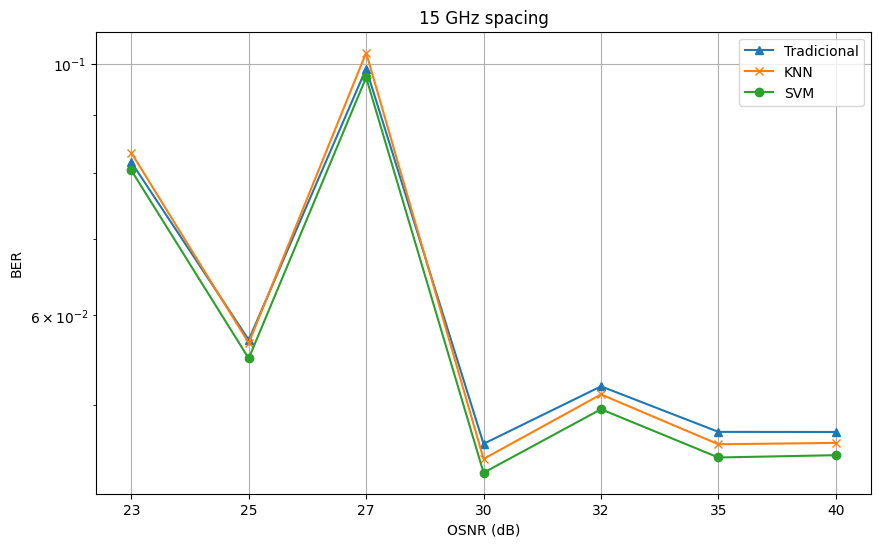

In [12]:
spacing = "15"
spacing_ber_eval(spacing)

In [13]:
print(f"Final: {datetime.datetime.now()}")

Final: 2023-02-22 02:22:27.808173
